<a href="https://colab.research.google.com/github/Masciel-Sevilla/modelos/blob/main/filtromfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-80y532kx
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-80y532kx
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440291 sha256=9691ea3a55b1aa00eacb49d3c513d5357073e9354ed134df810f0833c6544421
  Stored in directory: /tmp/pip-ephem-wheel-cache-ts6j2m75/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'aspp_module_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Modelo cargado exitosamente.

Iniciando evaluación con y sin CRF...

--- Resultados Detallados por Clase ---
Clase           | IoU Sin CRF     | IoU Con CRF     | Cambio (%)
-----------------------------------------------------------------
Background      | 0.9491          | 0.9524          | +0.35%
Cow-tongue      | 0.9056          | 0.8957          | -1.09%
Dandelion       | 0.8930          | 0.8884          | -0.52%
Kikuyo          | 0.8937          | 0.8864          | -0.81%
Other           | 0.7087          | 0.7068          | -0.27%
Potato          | 0.8881          | 0.8832          | -0.55%
-----------------------------------------------------------------
mIoU Promedio   | 0.8730          | 0.8688          | -0.48%

Visualizando un ejemplo...


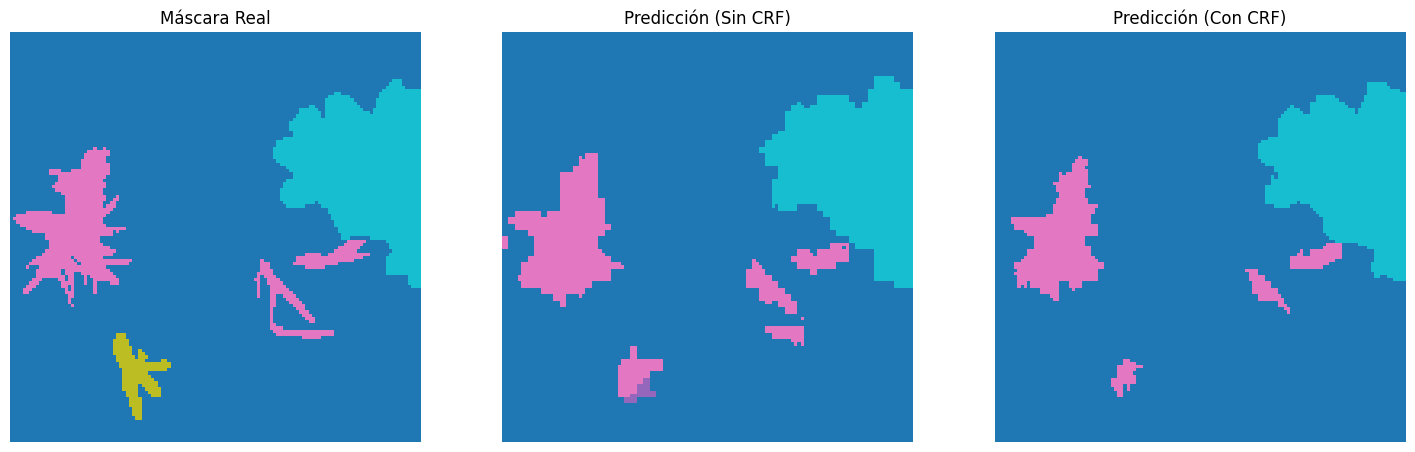

In [2]:
# ==============================================================================
# PASO 1: INSTALAR LIBRERÍAS
# ==============================================================================
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

# ==============================================================================
# PASO 2: IMPORTAR LIBRERÍAS
# ==============================================================================
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, create_pairwise_gaussian

# ==============================================================================
# PASO 3: CONFIGURACIÓN Y RUTAS
# ==============================================================================
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 6
CLASS_NAMES = ['Background', 'Cow-tongue', 'Dandelion', 'Kikuyo', 'Other', 'Potato']
MODEL_SAVE_PATH = 'efficient_weed_model_S.keras'
BASE_PATH = './Balanced'
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'val/images')
VAL_MASKS_PATH = os.path.join(BASE_PATH, 'val/masks')


# ==============================================================================
# PASO 4: DEFINICIONES COMPLETAS PARA CARGAR EL MODELO
# ==============================================================================

# --- Clases personalizadas ---
class ASPPModule(layers.Layer):
    def __init__(self, filters=192, **kwargs):
        super(ASPPModule, self).__init__(**kwargs)
        self.filters = filters
        self.conv_1x1 = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1 = layers.BatchNormalization()
        self.relu_1x1 = layers.ReLU()
        self.conv_3x3_6 = layers.Conv2D(filters, 3, padding='same', dilation_rate=6, use_bias=False)
        self.bn_3x3_6 = layers.BatchNormalization()
        self.relu_3x3_6 = layers.ReLU()
        self.conv_3x3_12 = layers.Conv2D(filters, 3, padding='same', dilation_rate=12, use_bias=False)
        self.bn_3x3_12 = layers.BatchNormalization()
        self.relu_3x3_12 = layers.ReLU()
        self.conv_3x3_18 = layers.Conv2D(filters, 3, padding='same', dilation_rate=18, use_bias=False)
        self.bn_3x3_18 = layers.BatchNormalization()
        self.relu_3x3_18 = layers.ReLU()
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=True)
        self.conv_1x1_gap = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_1x1_gap = layers.BatchNormalization()
        self.relu_1x1_gap = layers.ReLU()
        self.conv_final = layers.Conv2D(filters, 1, padding='same', use_bias=False)
        self.bn_final = layers.BatchNormalization()
        self.relu_final = layers.ReLU()
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        conv_1x1 = self.relu_1x1(self.bn_1x1(self.conv_1x1(inputs), training=training))
        conv_3x3_6 = self.relu_3x3_6(self.bn_3x3_6(self.conv_3x3_6(inputs), training=training))
        conv_3x3_12 = self.relu_3x3_12(self.bn_3x3_12(self.conv_3x3_12(inputs), training=training))
        conv_3x3_18 = self.relu_3x3_18(self.bn_3x3_18(self.conv_3x3_18(inputs), training=training))
        gap = self.global_avg_pool(inputs)
        gap = self.relu_1x1_gap(self.bn_1x1_gap(self.conv_1x1_gap(gap), training=training))
        gap = tf.image.resize(gap, [input_shape[1], input_shape[2]], method='bilinear')
        concat = layers.Concatenate()([conv_1x1, conv_3x3_6, conv_3x3_12, conv_3x3_18, gap])
        output = self.relu_final(self.bn_final(self.conv_final(concat), training=training))
        output = self.dropout(output, training=training)
        return output

class DeformableAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(DeformableAttention, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.attention_conv = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid', name='attention_weights_conv', use_bias=False)
        self.bn_attention = layers.BatchNormalization()
        self.feature_conv = layers.SeparableConv2D(self.filters, 3, padding='same', name='feature_processing_conv', use_bias=False)
        self.bn_feature = layers.BatchNormalization()
        self.relu_feature = layers.ReLU()
        super(DeformableAttention, self).build(input_shape)

    def call(self, inputs, training=None):
        attention_weights = self.bn_attention(self.attention_conv(inputs), training=training)
        features = self.relu_feature(self.bn_feature(self.feature_conv(inputs), training=training))
        attended_features = features * attention_weights
        return attended_features

# --- Funciones personalizadas ---
def dice_coefficient(y_true, y_pred): return 0.0
def combined_loss(y_true, y_pred): return 0.0

def iou_per_class(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    # Asegurarse de que y_pred sea one-hot
    if y_pred.shape[-1] != NUM_CLASSES:
      y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=NUM_CLASSES)
    else:
      y_pred = tf.cast(y_pred, tf.float32)

    # Calcular intersección y unión por clase (eje 3) sobre las dimensiones espaciales (ejes 1 y 2)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection

    # Evitar división por cero
    iou = tf.where(tf.equal(union, 0), 1.0, intersection / union)

    # El lote de entrada es de tamaño 1, así que eliminamos esa dimensión
    return tf.squeeze(iou)

def iou_metric(y_true, y_pred):
    # Esta función ahora simplemente promedia el resultado de iou_per_class
    return tf.reduce_mean(iou_per_class(y_true, y_pred))

# --- Función CRF ---
def refine_segmentation_with_crf(image, softmax_output, crf_params):
    image = np.ascontiguousarray(image)
    unary = unary_from_softmax(softmax_output)
    unary = np.ascontiguousarray(unary)

    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], softmax_output.shape[0])
    d.setUnaryEnergy(unary)

    d.addPairwiseEnergy(create_pairwise_gaussian(sdims=(crf_params['g_sdims'], crf_params['g_sdims']), shape=image.shape[:2]),
                        compat=crf_params['g_compat'], kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    d.addPairwiseEnergy(create_pairwise_bilateral(sdims=(crf_params['b_sdims'], crf_params['b_sdims']),
                                                  schan=(crf_params['b_rgb_sdims'], crf_params['b_rgb_sdims'], crf_params['b_rgb_sdims']),
                                                  img=image, chdim=2),
                        compat=crf_params['b_compat'], kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(crf_params['iterations'])
    refined_map = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))
    return refined_map

# ==============================================================================
# PASO 5: CARGAR DATOS DE VALIDACIÓN
# ==============================================================================
def load_validation_data(val_img_path, val_msk_path):
    val_image_paths = sorted(glob(os.path.join(val_img_path, '*.jpg')))
    val_mask_paths = sorted(glob(os.path.join(val_msk_path, '*.png')))
    if not val_image_paths or not val_mask_paths:
        raise FileNotFoundError(f"No se encontraron imágenes o máscaras en: {val_img_path}, {val_msk_path}")
    val_ds_original = tf.data.Dataset.from_tensor_slices(val_image_paths).map(lambda p: tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(p), channels=3), [IMG_HEIGHT, IMG_WIDTH]))
    val_ds_processed = val_ds_original.map(tf.keras.applications.efficientnet_v2.preprocess_input)
    val_ds_masks = tf.data.Dataset.from_tensor_slices(val_mask_paths).map(lambda p: tf.one_hot(tf.squeeze(tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(p), channels=1), [IMG_HEIGHT, IMG_WIDTH], method='nearest'), tf.int32)), depth=NUM_CLASSES))
    full_val_ds = tf.data.Dataset.zip((val_ds_original, val_ds_processed, val_ds_masks))
    return full_val_ds.batch(1)

# ==============================================================================
# PASO 6: EJECUTAR LA EVALUACIÓN CON MÉTRICAS POR CLASE
# ==============================================================================
if __name__ == "__main__":
    custom_objects = {
        'combined_loss': combined_loss,
        'dice_coefficient': dice_coefficient,
        'iou_metric': iou_metric,
        'ASPPModule': ASPPModule,
        'DeformableAttention': DeformableAttention
    }
    try:
        model = tf.keras.models.load_model(MODEL_SAVE_PATH, custom_objects=custom_objects)
        print("Modelo cargado exitosamente.")

        val_dataset = load_validation_data(VAL_IMAGES_PATH, VAL_MASKS_PATH)

        # Listas para almacenar los vectores de IoU de cada imagen
        per_class_iou_no_crf_list = []
        per_class_iou_with_crf_list = []

        crf_parameters = { 'g_sdims': 3, 'g_compat': 1, 'b_sdims': 80, 'b_rgb_sdims': 13, 'b_compat':5, 'iterations': 5 }
        print("\nIniciando evaluación con y sin CRF...")

        for image_original, image_processed, mask_true_one_hot in val_dataset:
            probs_pred = model.predict(image_processed, verbose=0)[0]
            image_uint8 = tf.cast(image_original[0], tf.uint8).numpy()

            # --- Sin CRF ---
            mask_pred_no_crf = np.argmax(probs_pred, axis=-1)
            iou_vector_no_crf = iou_per_class(mask_true_one_hot, mask_pred_no_crf[np.newaxis, ...])
            per_class_iou_no_crf_list.append(iou_vector_no_crf.numpy())

            # --- Con CRF ---
            probs_for_crf = probs_pred.transpose(2, 0, 1)
            mask_pred_with_crf = refine_segmentation_with_crf(image_uint8, probs_for_crf, crf_parameters)
            iou_vector_with_crf = iou_per_class(mask_true_one_hot, mask_pred_with_crf[np.newaxis, ...])
            per_class_iou_with_crf_list.append(iou_vector_with_crf.numpy())

        # --- Calcular promedios finales ---
        avg_iou_per_class_no_crf = np.mean(per_class_iou_no_crf_list, axis=0)
        avg_iou_per_class_with_crf = np.mean(per_class_iou_with_crf_list, axis=0)

        # Calcular el mIoU total a partir de los promedios por clase
        mIoU_no_crf = np.mean(avg_iou_per_class_no_crf)
        mIoU_with_crf = np.mean(avg_iou_per_class_with_crf)

        # --- Imprimir resultados detallados ---
        print("\n--- Resultados Detallados por Clase ---")
        print(f"{'Clase':<15} | {'IoU Sin CRF':<15} | {'IoU Con CRF':<15} | {'Cambio (%)'}")
        print("-" * 65)
        for i, class_name in enumerate(CLASS_NAMES):
            iou_sin = avg_iou_per_class_no_crf[i]
            iou_con = avg_iou_per_class_with_crf[i]
            cambio = ((iou_con - iou_sin) / iou_sin) * 100 if iou_sin > 0 else 0
            print(f"{class_name:<15} | {iou_sin:<15.4f} | {iou_con:<15.4f} | {cambio:+.2f}%")

        print("-" * 65)
        print(f"{'mIoU Promedio':<15} | {mIoU_no_crf:<15.4f} | {mIoU_with_crf:<15.4f} | {((mIoU_with_crf - mIoU_no_crf) / mIoU_no_crf)*100:+.2f}%")

        # --- Visualizar un ejemplo ---
        print("\nVisualizando un ejemplo...")
        image_original, image_processed, mask_true_one_hot = next(iter(val_dataset))
        probs_pred = model.predict(image_processed, verbose=0)[0]
        image_uint8 = tf.cast(image_original[0], tf.uint8).numpy()
        mask_pred_no_crf = np.argmax(probs_pred, axis=-1)
        probs_for_crf = probs_pred.transpose(2, 0, 1)
        mask_pred_with_crf = refine_segmentation_with_crf(image_uint8, probs_for_crf, crf_parameters)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(np.argmax(mask_true_one_hot[0].numpy(), axis=-1), cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[0].set_title('Máscara Real'); axes[0].axis('off')
        axes[1].imshow(mask_pred_no_crf, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[1].set_title('Predicción (Sin CRF)'); axes[1].axis('off')
        axes[2].imshow(mask_pred_with_crf, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[2].set_title('Predicción (Con CRF)'); axes[2].axis('off')
        plt.show()

    except Exception as e:
        print(f"\nERROR: Ocurrió un problema durante la ejecución.")
        print(f"Asegúrate de que el archivo del modelo '{MODEL_SAVE_PATH}' y los datos de validación existan.")
        print(f"Error original: {e}")


In [1]:
# Paso 1: Descomprimir el dataset (esto solo se hace una vez)
import os
import zipfile

zip_path = '/content/Balanced.zip'
extract_path = '/content/'

# Solo descomprimir si no se ha hecho antes
if not os.path.exists(os.path.join(extract_path, 'Balanced')):
    print(f"Descomprimiendo {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("¡Descompresión completada!")
else:
    print("La carpeta 'Balanced' ya existe. Omitiendo descompresión.")

Descomprimiendo /content/Balanced.zip...
¡Descompresión completada!
